# Black Scholes Model

\begin{equation*}
C = S_t N \left(d1 \right) - K e^{-rt} N \left(d2 \right)
\end{equation*}

__Where:__

\begin{equation*}
d1 = \frac{ \ln{ \frac{S_t}{K} + \left(r + \frac{\sigma_u^2}{2} \right) t} }{\sigma_s \sqrt{t}}
\end{equation*}

and:

\begin{equation*}
d2 = d1 -  \sigma_s \sqrt{t}
\end{equation*}


__Where:__

\begin{alignat*}{}
&C \quad & = \quad & \text{Call option price} \\
&S \quad & = \quad & \text{Current stock (or other underlying) price} \\
&K \quad & = \quad & \text{Strike price} \\
&r \quad & = \quad & \text{Risk-free interest rate} \\
&t \quad & = \quad & \text{time to maturity} \\
&N \quad & = \quad & \text{A normal distribution}
\end{alignat*}

In [1]:
#pip install stockquotes
#pip install Quandl

import math
import scipy.stats as st
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import stockquotes
import quandl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
# @hidden_cell
quandl.ApiConfig.api_key = 'JMxryiBcRV26o9r5q7uv'

In [3]:
S = 3097.74
K = 3100
r = 0.0012
t = 24/365
sigma = 0.235957486878604

In [4]:
d1 = (math.log(S/K)+(r+((sigma**2)/2))*t)/(sigma*math.sqrt(t))
d2 = d1 - sigma*math.sqrt(t)
N_d1 = st.norm.cdf(d1)
N_d2 = st.norm.cdf(d2)
C = S*N_d1-K*math.exp(-r*t)*N_d2
C

73.78307869939204

In [5]:
GSPC = yf.Ticker('^GSPC')

In [6]:
expirations = GSPC.options
expirations

('2020-12-17', '2021-12-16')

In [7]:
GSPC_opts = GSPC.option_chain(expirations[0])
GSPC_opts

Options(calls=        contractSymbol       lastTradeDate  strike  lastPrice      bid  \
0   SPX201218C00100000 2020-06-17 17:28:59   100.0    3012.68  3011.50   
1   SPX201218C00200000 2020-06-18 16:31:43   200.0    2878.00  2911.70   
2   SPX201218C00300000 2020-06-02 19:11:54   300.0    2738.00  2767.90   
3   SPX201218C00400000 2020-06-02 19:11:51   400.0    2638.40  2668.40   
4   SPX201218C00500000 2020-06-09 23:08:40   500.0    1790.50  2621.20   
..                 ...                 ...     ...        ...      ...   
89  SPX201218C03800000 2020-07-02 18:36:45  3800.0       9.27     8.40   
90  SPX201218C03900000 2020-07-02 20:02:52  3900.0       5.50     5.40   
91  SPX201218C04000000 2020-07-02 19:48:02  4000.0       3.80     3.60   
92  SPX201218C04100000 2020-07-02 16:58:11  4100.0       2.77     2.55   
93  SPX201218C04200000 2020-07-02 19:48:28  4200.0       1.94     1.85   

        ask  change  percentChange  volume  openInterest  impliedVolatility  \
0   3016.00    0.0

In [8]:
GSPC_calls = GSPC_opts.calls
GSPC_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPX201218C00100000,2020-06-17 17:28:59,100.0,3012.68,3011.50,3016.00,0.00,0.000000,345,3263,0.000010,True,REGULAR,USD
1,SPX201218C00200000,2020-06-18 16:31:43,200.0,2878.00,2911.70,2916.20,0.00,0.000000,73,3137,0.000010,True,REGULAR,USD
2,SPX201218C00300000,2020-06-02 19:11:54,300.0,2738.00,2767.90,2772.40,0.00,0.000000,8,86,0.000010,True,REGULAR,USD
3,SPX201218C00400000,2020-06-02 19:11:51,400.0,2638.40,2668.40,2672.80,0.00,0.000000,6,16,0.000010,True,REGULAR,USD
4,SPX201218C00500000,2020-06-09 23:08:40,500.0,1790.50,2621.20,2625.40,0.00,0.000000,0,59,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,SPX201218C03800000,2020-07-02 18:36:45,3800.0,9.27,8.40,8.90,1.05,12.773725,281,14514,0.174958,False,REGULAR,USD
90,SPX201218C03900000,2020-07-02 20:02:52,3900.0,5.50,5.40,5.90,0.20,3.773581,54,7169,0.178536,False,REGULAR,USD
91,SPX201218C04000000,2020-07-02 19:48:02,4000.0,3.80,3.60,4.10,0.20,5.555557,62,7353,0.183327,False,REGULAR,USD
92,SPX201218C04100000,2020-07-02 16:58:11,4100.0,2.77,2.55,2.95,0.03,1.094890,503,2227,0.188668,False,REGULAR,USD


In [9]:
K = GSPC_calls['strike']

In [10]:
expiration_date = datetime.strptime(expirations[0],"%Y-%m-%d") 
today = datetime.now()

t = (expiration_date - today).days/365

In [11]:
SP500 = stockquotes.Stock("^GSPC")
S = SP500.current_price

In [12]:
# @hidden_cell
yield_curve = quandl.get("USTREASURY/YIELD", authtoken="JMxryiBcRV26o9r5q7uv")
yield_curve

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.12,0.15,0.14,0.17,0.17,0.17,0.19,0.30,0.49,0.64,1.15,1.37
2020-06-29,0.11,0.14,0.14,0.18,0.16,0.16,0.18,0.28,0.47,0.64,1.16,1.39
2020-06-30,0.13,0.14,0.16,0.18,0.16,0.16,0.18,0.29,0.49,0.66,1.18,1.41


In [13]:
time_to_maturity = (expiration_date - today).days
if round(time_to_maturity) < 365:
    print(f"There are {round(time_to_maturity/30)} months to maturity")
elif round(time_to_maturity) == 365:
    print(f"There is {round(time_to_maturity/365,1)} year to maturity")
else:
    print(f"There are {round(time_to_maturity/365,1)} years to maturity")

There are 6 months to maturity


In [14]:
r = yield_curve['6 MO'][-1]/100

In [15]:
sigma = GSPC_calls['impliedVolatility']

In [16]:
def Norm_d1(S, K, r, t, sigma):
    d1 = (np.log(S/K)+(r+((np.power(sigma,2)/2))*t))/(sigma*math.sqrt(t))
    N_d1 = st.norm.cdf(d1)
    return (d1, N_d1)

In [17]:
def Norm_d2(d1, sigma, t):
    d2 = d1 - sigma*math.sqrt(t)
    N_d2 = st.norm.cdf(d2)
    return N_d2

In [18]:
def Call_price(S, K, r, t, sigma):
    d1, N_d1 = Norm_d1(S, K, r, t, sigma)
    N_d2 = Norm_d2(d1, sigma, t)
    C = S*N_d1-K*math.exp(-r*t)*N_d2
    return C

In [19]:
d1, N_d1 = Norm_d1(S, K, r, t, sigma)

In [20]:
N_d2 = Norm_d2(d1, sigma, t)

In [21]:
C = Call_price(S, K, r, t, sigma)
C

0     3030.082741
1     2930.155481
2     2830.228222
3     2730.300963
4     2630.373703
         ...     
89       8.631663
90       5.688980
91       3.932472
92       2.814781
93       2.087963
Name: strike, Length: 94, dtype: float64

In [22]:
for i in C:
    for n in K:
        print(f"The call price is {round(i,2)} with a expiration on {expirations[0]} and strike price of {n}")
        print('-'*83)

The call price is 3030.08 with a expiration on 2020-12-17 and strike price of 100.0
-----------------------------------------------------------------------------------
The call price is 3030.08 with a expiration on 2020-12-17 and strike price of 200.0
-----------------------------------------------------------------------------------
The call price is 3030.08 with a expiration on 2020-12-17 and strike price of 300.0
-----------------------------------------------------------------------------------
The call price is 3030.08 with a expiration on 2020-12-17 and strike price of 400.0
-----------------------------------------------------------------------------------
The call price is 3030.08 with a expiration on 2020-12-17 and strike price of 500.0
-----------------------------------------------------------------------------------
The call price is 3030.08 with a expiration on 2020-12-17 and strike price of 600.0
----------------------------------------------------------------------------

-----------------------------------------------------------------------------------
The call price is 2730.3 with a expiration on 2020-12-17 and strike price of 2950.0
-----------------------------------------------------------------------------------
The call price is 2730.3 with a expiration on 2020-12-17 and strike price of 2975.0
-----------------------------------------------------------------------------------
The call price is 2730.3 with a expiration on 2020-12-17 and strike price of 3000.0
-----------------------------------------------------------------------------------
The call price is 2730.3 with a expiration on 2020-12-17 and strike price of 3025.0
-----------------------------------------------------------------------------------
The call price is 2730.3 with a expiration on 2020-12-17 and strike price of 3050.0
-----------------------------------------------------------------------------------
The call price is 2730.3 with a expiration on 2020-12-17 and strike price of

The call price is 2230.66 with a expiration on 2020-12-17 and strike price of 950.0
-----------------------------------------------------------------------------------
The call price is 2230.66 with a expiration on 2020-12-17 and strike price of 1000.0
-----------------------------------------------------------------------------------
The call price is 2230.66 with a expiration on 2020-12-17 and strike price of 1050.0
-----------------------------------------------------------------------------------
The call price is 2230.66 with a expiration on 2020-12-17 and strike price of 1100.0
-----------------------------------------------------------------------------------
The call price is 2230.66 with a expiration on 2020-12-17 and strike price of 1200.0
-----------------------------------------------------------------------------------
The call price is 2230.66 with a expiration on 2020-12-17 and strike price of 1450.0
-----------------------------------------------------------------------

The call price is 2130.74 with a expiration on 2020-12-17 and strike price of 2400.0
-----------------------------------------------------------------------------------
The call price is 2130.74 with a expiration on 2020-12-17 and strike price of 2425.0
-----------------------------------------------------------------------------------
The call price is 2130.74 with a expiration on 2020-12-17 and strike price of 2450.0
-----------------------------------------------------------------------------------
The call price is 2130.74 with a expiration on 2020-12-17 and strike price of 2475.0
-----------------------------------------------------------------------------------
The call price is 2130.74 with a expiration on 2020-12-17 and strike price of 2500.0
-----------------------------------------------------------------------------------
The call price is 2130.74 with a expiration on 2020-12-17 and strike price of 2525.0
----------------------------------------------------------------------

The call price is 1431.25 with a expiration on 2020-12-17 and strike price of 2350.0
-----------------------------------------------------------------------------------
The call price is 1431.25 with a expiration on 2020-12-17 and strike price of 2375.0
-----------------------------------------------------------------------------------
The call price is 1431.25 with a expiration on 2020-12-17 and strike price of 2400.0
-----------------------------------------------------------------------------------
The call price is 1431.25 with a expiration on 2020-12-17 and strike price of 2425.0
-----------------------------------------------------------------------------------
The call price is 1431.25 with a expiration on 2020-12-17 and strike price of 2450.0
-----------------------------------------------------------------------------------
The call price is 1431.25 with a expiration on 2020-12-17 and strike price of 2475.0
----------------------------------------------------------------------

-----------------------------------------------------------------------------------
The call price is 1356.49 with a expiration on 2020-12-17 and strike price of 1100.0
-----------------------------------------------------------------------------------
The call price is 1356.49 with a expiration on 2020-12-17 and strike price of 1200.0
-----------------------------------------------------------------------------------
The call price is 1356.49 with a expiration on 2020-12-17 and strike price of 1450.0
-----------------------------------------------------------------------------------
The call price is 1356.49 with a expiration on 2020-12-17 and strike price of 1500.0
-----------------------------------------------------------------------------------
The call price is 1356.49 with a expiration on 2020-12-17 and strike price of 1550.0
-----------------------------------------------------------------------------------
The call price is 1356.49 with a expiration on 2020-12-17 and strike pr

The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 1775.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 1800.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 1825.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 1850.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 1875.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 1900.0
----------------------------------------------------------------------

The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 3025.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 3050.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 3075.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 3100.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 3125.0
-----------------------------------------------------------------------------------
The call price is 1115.94 with a expiration on 2020-12-17 and strike price of 3150.0
----------------------------------------------------------------------

The call price is 929.99 with a expiration on 2020-12-17 and strike price of 2975.0
-----------------------------------------------------------------------------------
The call price is 929.99 with a expiration on 2020-12-17 and strike price of 3000.0
-----------------------------------------------------------------------------------
The call price is 929.99 with a expiration on 2020-12-17 and strike price of 3025.0
-----------------------------------------------------------------------------------
The call price is 929.99 with a expiration on 2020-12-17 and strike price of 3050.0
-----------------------------------------------------------------------------------
The call price is 929.99 with a expiration on 2020-12-17 and strike price of 3075.0
-----------------------------------------------------------------------------------
The call price is 929.99 with a expiration on 2020-12-17 and strike price of 3100.0
----------------------------------------------------------------------------

-----------------------------------------------------------------------------------
The call price is 862.05 with a expiration on 2020-12-17 and strike price of 2175.0
-----------------------------------------------------------------------------------
The call price is 862.05 with a expiration on 2020-12-17 and strike price of 2200.0
-----------------------------------------------------------------------------------
The call price is 862.05 with a expiration on 2020-12-17 and strike price of 2225.0
-----------------------------------------------------------------------------------
The call price is 862.05 with a expiration on 2020-12-17 and strike price of 2250.0
-----------------------------------------------------------------------------------
The call price is 862.05 with a expiration on 2020-12-17 and strike price of 2275.0
-----------------------------------------------------------------------------------
The call price is 862.05 with a expiration on 2020-12-17 and strike price of

-----------------------------------------------------------------------------------
The call price is 686.56 with a expiration on 2020-12-17 and strike price of 2125.0
-----------------------------------------------------------------------------------
The call price is 686.56 with a expiration on 2020-12-17 and strike price of 2150.0
-----------------------------------------------------------------------------------
The call price is 686.56 with a expiration on 2020-12-17 and strike price of 2175.0
-----------------------------------------------------------------------------------
The call price is 686.56 with a expiration on 2020-12-17 and strike price of 2200.0
-----------------------------------------------------------------------------------
The call price is 686.56 with a expiration on 2020-12-17 and strike price of 2225.0
-----------------------------------------------------------------------------------
The call price is 686.56 with a expiration on 2020-12-17 and strike price of

The call price is 665.31 with a expiration on 2020-12-17 and strike price of 800.0
-----------------------------------------------------------------------------------
The call price is 665.31 with a expiration on 2020-12-17 and strike price of 900.0
-----------------------------------------------------------------------------------
The call price is 665.31 with a expiration on 2020-12-17 and strike price of 950.0
-----------------------------------------------------------------------------------
The call price is 665.31 with a expiration on 2020-12-17 and strike price of 1000.0
-----------------------------------------------------------------------------------
The call price is 665.31 with a expiration on 2020-12-17 and strike price of 1050.0
-----------------------------------------------------------------------------------
The call price is 665.31 with a expiration on 2020-12-17 and strike price of 1100.0
-------------------------------------------------------------------------------

-----------------------------------------------------------------------------------
The call price is 500.84 with a expiration on 2020-12-17 and strike price of 3500.0
-----------------------------------------------------------------------------------
The call price is 500.84 with a expiration on 2020-12-17 and strike price of 3600.0
-----------------------------------------------------------------------------------
The call price is 500.84 with a expiration on 2020-12-17 and strike price of 3700.0
-----------------------------------------------------------------------------------
The call price is 500.84 with a expiration on 2020-12-17 and strike price of 3800.0
-----------------------------------------------------------------------------------
The call price is 500.84 with a expiration on 2020-12-17 and strike price of 3900.0
-----------------------------------------------------------------------------------
The call price is 500.84 with a expiration on 2020-12-17 and strike price of

-----------------------------------------------------------------------------------
The call price is 441.26 with a expiration on 2020-12-17 and strike price of 300.0
-----------------------------------------------------------------------------------
The call price is 441.26 with a expiration on 2020-12-17 and strike price of 400.0
-----------------------------------------------------------------------------------
The call price is 441.26 with a expiration on 2020-12-17 and strike price of 500.0
-----------------------------------------------------------------------------------
The call price is 441.26 with a expiration on 2020-12-17 and strike price of 600.0
-----------------------------------------------------------------------------------
The call price is 441.26 with a expiration on 2020-12-17 and strike price of 650.0
-----------------------------------------------------------------------------------
The call price is 441.26 with a expiration on 2020-12-17 and strike price of 700.

The call price is 277.87 with a expiration on 2020-12-17 and strike price of 2125.0
-----------------------------------------------------------------------------------
The call price is 277.87 with a expiration on 2020-12-17 and strike price of 2150.0
-----------------------------------------------------------------------------------
The call price is 277.87 with a expiration on 2020-12-17 and strike price of 2175.0
-----------------------------------------------------------------------------------
The call price is 277.87 with a expiration on 2020-12-17 and strike price of 2200.0
-----------------------------------------------------------------------------------
The call price is 277.87 with a expiration on 2020-12-17 and strike price of 2225.0
-----------------------------------------------------------------------------------
The call price is 277.87 with a expiration on 2020-12-17 and strike price of 2250.0
----------------------------------------------------------------------------

-----------------------------------------------------------------------------------
The call price is 261.06 with a expiration on 2020-12-17 and strike price of 2975.0
-----------------------------------------------------------------------------------
The call price is 261.06 with a expiration on 2020-12-17 and strike price of 3000.0
-----------------------------------------------------------------------------------
The call price is 261.06 with a expiration on 2020-12-17 and strike price of 3025.0
-----------------------------------------------------------------------------------
The call price is 261.06 with a expiration on 2020-12-17 and strike price of 3050.0
-----------------------------------------------------------------------------------
The call price is 261.06 with a expiration on 2020-12-17 and strike price of 3075.0
-----------------------------------------------------------------------------------
The call price is 261.06 with a expiration on 2020-12-17 and strike price of

The call price is 91.72 with a expiration on 2020-12-17 and strike price of 1875.0
-----------------------------------------------------------------------------------
The call price is 91.72 with a expiration on 2020-12-17 and strike price of 1900.0
-----------------------------------------------------------------------------------
The call price is 91.72 with a expiration on 2020-12-17 and strike price of 1925.0
-----------------------------------------------------------------------------------
The call price is 91.72 with a expiration on 2020-12-17 and strike price of 1950.0
-----------------------------------------------------------------------------------
The call price is 91.72 with a expiration on 2020-12-17 and strike price of 1975.0
-----------------------------------------------------------------------------------
The call price is 91.72 with a expiration on 2020-12-17 and strike price of 2000.0
----------------------------------------------------------------------------------

The call price is 41.52 with a expiration on 2020-12-17 and strike price of 1850.0
-----------------------------------------------------------------------------------
The call price is 41.52 with a expiration on 2020-12-17 and strike price of 1875.0
-----------------------------------------------------------------------------------
The call price is 41.52 with a expiration on 2020-12-17 and strike price of 1900.0
-----------------------------------------------------------------------------------
The call price is 41.52 with a expiration on 2020-12-17 and strike price of 1925.0
-----------------------------------------------------------------------------------
The call price is 41.52 with a expiration on 2020-12-17 and strike price of 1950.0
-----------------------------------------------------------------------------------
The call price is 41.52 with a expiration on 2020-12-17 and strike price of 1975.0
----------------------------------------------------------------------------------

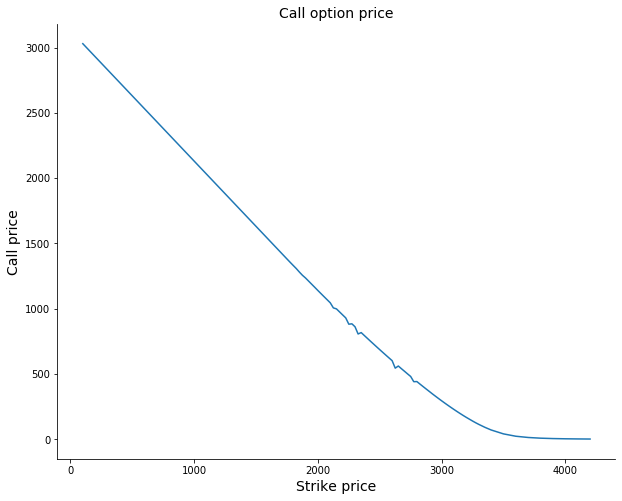

In [23]:
plt.figure(figsize=(10,8))

plt.plot(K, C)

plt.title("Call option price", fontsize=14)
plt.xlabel("Strike price", fontsize=14)
plt.ylabel("Call price", fontsize=14)

ax = plt.gca()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.show()

In [24]:
expirations = GSPC.options

exp_dates = []

for a in expirations:
    exp_dates.append(a)

K = {name: pd.DataFrame()for name in exp_dates}

for i, a in enumerate(expirations):
    GSPC_opts = GSPC.option_chain(expirations[i])
    GSPC_calls = GSPC_opts.calls
    K[a] = GSPC_calls['strike']


In [25]:
t = {name: pd.DataFrame() for name in exp_dates}

for i, a in enumerate(expirations):
    expiration_date = datetime.strptime(expirations[i],"%Y-%m-%d") 
    today = datetime.now()
    t[a] = (expiration_date - today).days/365

In [26]:
SP500 = stockquotes.Stock("^GSPC")
S = SP500.current_price

In [36]:
def TTM(exp_date,today):
    time_to_maturity = (exp_date - today).days
    return time_to_maturity

def rf(exp_date,today):
    num_days = [30,60,90,180,365,730,1095,1825,2555,3650,7300,10950]
    rf_ttm = list(yield_curve.columns)
    if round(TTM(exp_date,today)) < 0:
        output = print("Expire date must be greater than today")
    else:
#         output = print("No input")
        for i, n in enumerate(num_days):
            if round(TTM(exp_date,today)) < n:
                rf = yield_curve[rf_ttm[0]][-1]/100
            elif round(TTM(exp_date,today)) > n:
                rf = yield_curve[rf_ttm[i]][-1]/100
    return rf

expiration_date = datetime.strptime('2019-07-15',"%Y-%m-%d") 
today = datetime.now()

rf(expiration_date,today)

SyntaxError: invalid syntax (<ipython-input-36-88ae19ec7b6a>, line 10)